## Run PyMC model on GPy ICM example data

Replicate this example from GPy:

Notes: https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

In [141]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [142]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=np.sort(X1, axis=0); X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=np.sort(X2, axis=0); X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100; Xt1=np.sort(Xt1, axis=0)
Xt2 = np.random.rand(100)[:,None]*100; Xt2=np.sort(Xt2, axis=0)
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)
print(Xt1.shape, Xt2.shape, Yt1.shape, Yt2.shape)

(100, 1) (100, 1) (100, 1) (100, 1)


In [143]:
X1.mean(), X2.mean(), Y1.mean(), Y2.mean()

(39.53005587478105, 68.11474292992098, -49.52121600762811, 52.90984664004813)

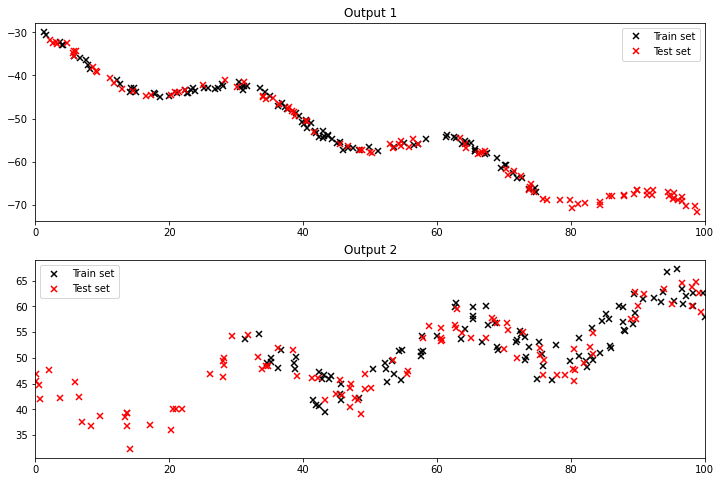

In [144]:
xlim = (0,100); ylim = (0,50)
fig, ax = plt.subplots(2, figsize=(12,8))

ax[0].set_xlim(xlim)
ax[0].set_title('Output 1')
ax[0].plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax[0].legend()

ax[1].set_xlim(xlim)
ax[1].set_title('Output 2')
ax[1].plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax[1].legend()
plt.show()

In [145]:
def plot_2outputs(m,xlim,ylim):   
    # Output 1
    fig, ax = plt.subplots(2, figsize=(12,8))
    ax[0].set_xlim(xlim)
    ax[0].set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax[0])
    ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    ax[0].legend()
    # Output 2
    ax[1].set_xlim(xlim)
    ax[1].set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax[1])
    ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
    ax[1].legend()
    plt.show()

In [146]:
X12 = np.concatenate((X1, X2), axis=0)
idx = np.concatenate((np.zeros(len(X1)), np.ones(len(X2))))[:, None]
X = np.concatenate((X12, idx), axis=1)
y = np.concatenate((Y1, Y2))
print(X12.shape, idx.shape, X.shape, y.shape)

(200, 1) (200, 1) (200, 2) (200, 1)


In [147]:
def build_XY(input_list,output_list=None,index=None):
    num_outputs = len(input_list)
    if output_list is not None:
        assert num_outputs == len(output_list)
        Y = np.vstack(output_list)
    else:
        Y = None

    if index is not None:
        assert len(index) == num_outputs
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,index)] )
    else:
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )

    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])

    return X,Y,I[:,None]#slices

In [148]:
X, Y, I = build_XY([X1, X2], 
                   [Y1, Y2])
X.shape, Y.shape, I.shape

((200, 2), (200, 1), (200, 1))

### PyMC model

In [149]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=5, beta=0.1)
    eta = pm.Gamma("eta", alpha=5, beta=0.1)
    cov = eta**2 * pm.gp.cov.Matern32(1, ls=ell, active_dims=[0])    

#     c = pm.HalfCauchy('c', 5)
#     eta = pm.HalfCauchy('eta', 1)
#     cov = eta * pm.gp.cov.Linear(input_dim=1, c=c, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=5, shape=(2,2), initval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=5, beta=0.1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)

#     period = pm.Gamma("period", alpha=5, beta=0.1)
#     cov2 = pm.gp.cov.Cosine(1, period, active_dims=[0])
#     W2 = pm.Normal("W2", mu=0, sigma=5, shape=(2,2), initval=np.random.randn(2,2))
#     kappa2 = pm.Gamma("kappa2", alpha=5, beta=0.1, shape=2)
#     coreg2 = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa2, W=W2)
    
    cov_func = coreg * cov
#     cov_func = coreg * cov + coreg2 * cov2
    
    sigma = pm.HalfNormal("sigma", sigma=30)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [150]:
%%time
with model:
    gp_trace = pm.sample(500, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 278 seconds.


CPU times: user 10.5 s, sys: 7.18 s, total: 17.6 s
Wall time: 4min 42s


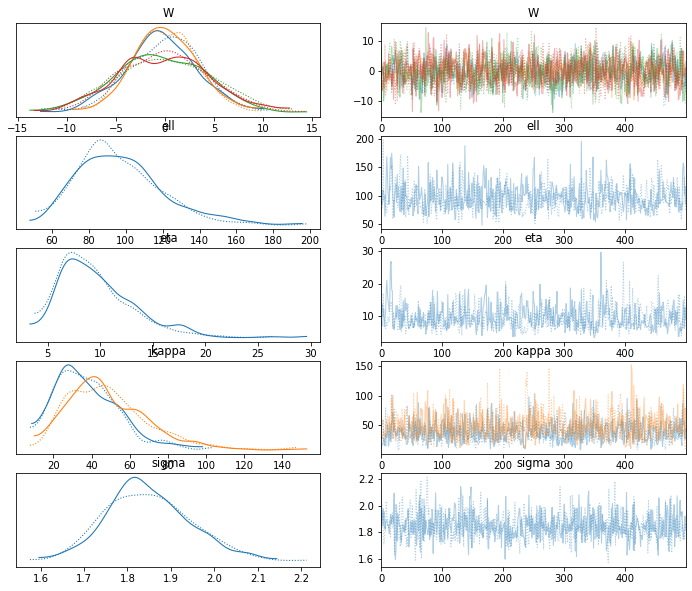

In [151]:
az.plot_trace(gp_trace);

In [152]:
with model:
    pred = gp.conditional("preds", X)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


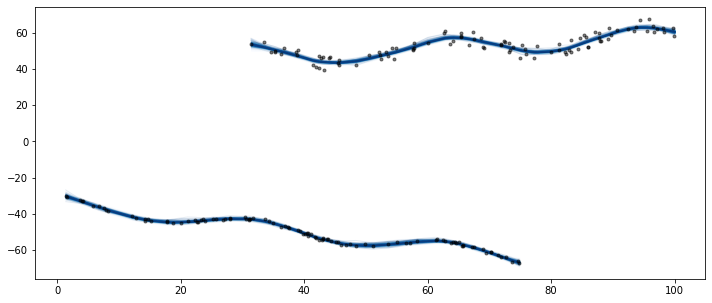

In [153]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:100], X[:100,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[:100,0], Y[:100,0], 'ok', ms=3, alpha=0.5, label="Data 1");

plot_gp_dist(ax, f_pred[:,100:], X[100:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X[100:,0], Y[100:,0], 'ok', ms=3, alpha=0.5, label="Data 1");

### Prediction

In [154]:
Xt12 = np.concatenate((Xt1, Xt2), axis=0)
idx = np.concatenate((np.zeros(len(Xt1)), np.ones(len(Xt2))))[:, None]
X_new = np.concatenate((Xt12, idx), axis=1)
yt = np.concatenate((Yt1, Yt2))
print(Xt12.shape, idx.shape, X_new.shape, yt.shape)

(200, 1) (200, 1) (200, 2) (200, 1)


In [155]:
X_new, Y_new, _ = build_XY([Xt1, Xt2], 
                   [Yt1, Yt2])
X_new.shape, Y_new.shape

((200, 2), (200, 1))

In [156]:
with model:
    pred = gp.conditional("pred", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['pred'], random_seed=42)

/home/danh/WORK/codes/oss/pymc/pymc/gp/cov.py:99: UserWarning: Only 1 column(s) out of 2 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(


In [157]:
gp_samples.posterior_predictive["pred"].sel(chain=0).shape

(500, 200)

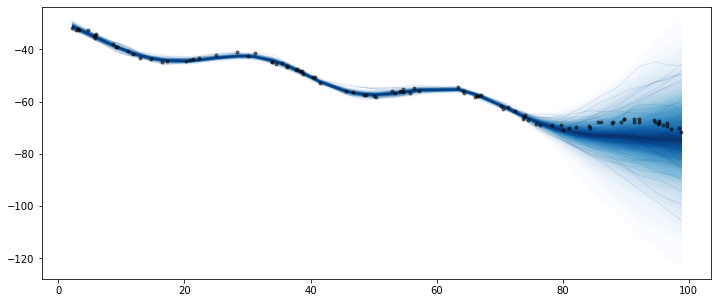

In [158]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = gp_samples.posterior_predictive["pred"].sel(chain=0)
plot_gp_dist(ax, f_pred[:,:100], X_new[:100,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(Xt1, Yt1, 'ok', ms=3, alpha=0.5, label="Data 1");


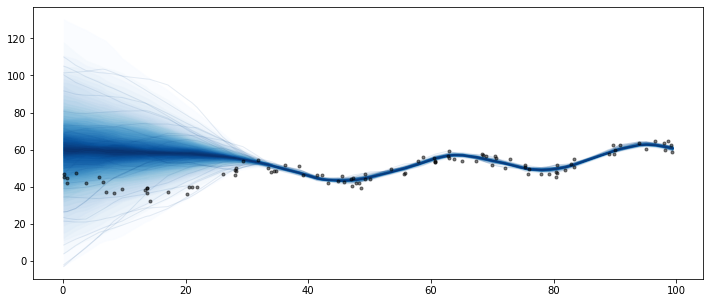

In [159]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

plot_gp_dist(ax, f_pred[:,100:], X_new[100:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(Xt2, Yt2, 'ok', ms=3, alpha=0.5, label="Data 1");

### References

https://nbviewer.org/github/SheffieldML/notebook/blob/master/GPy/coregionalized_regression_tutorial.ipynb

https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550/4